In [736]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 1. Chargement et Exploration des Données

1.Objectif du TP :

Analyser les données du Titanic pour identifier les facteurs influençant la survie des passagers en utilisant des techniques statistiques et des outils de visualisation de données.

- Importer le fichier "AM24-GSAP_data_2010-2019-2021.xlsx" à l'aide de Pandas.
- Examiner les premières lignes du dataset pour comprendre sa structure.
- Identifier les types de variables et vérifier la présence de valeurs manquantes.

In [737]:
# Chargement des données
df = pd.read_excel('AM24-GSAP_data_2010-2019-2021.xlsx')

2. Description des Données :

. Code Pays (code) : Identifie le pays (ici, TUN pour Tunisie).

. Année de Base (baseyear) et Année d'Alignement (lineupyear) : 2010.

. Nom de l'Enquête (survname) : NSHBCSL (probablement une enquête nationale sur le bien-être).

. Type de Bien-Être (welfaretype) : CONS (consommation comme mesure de bien-être).

. Échantillon Régional (sample) : Découpage en régions administratives et géographiques.

. Code Géographique (geo_code et geo_code2_new) : Identifiants régionaux uniques.

. Indicateurs de Pauvreté :
    
  - poor215_ln : Taux de pauvreté extrême.
  - poor365_ln : Taux de pauvreté modérée.
  - poor685_ln : Taux de pauvreté relative.
  - prosgap2017 : Indice d'écart de pauvreté.

In [738]:
# Affichage des premières lignes
print(df.head())

  code  baseyear  lineupyear   survname welfaretype          sample  \
0  AGO      2008        2010  IBEP-MICS        CONS         Cabinda   
1  AGO      2008        2010  IBEP-MICS        CONS          Huambo   
2  AGO      2008        2010  IBEP-MICS        CONS             Bie   
3  AGO      2008        2010  IBEP-MICS        CONS          Moxico   
4  AGO      2008        2010  IBEP-MICS        CONS  Cuando Cubango   

     vintage            geo_code  poor215_ln  poor365_ln  poor685_ln  \
0  Fall 2024  AGO_2015_GAUL1_401      0.0198      0.1877      0.6059   
1  Fall 2024  AGO_2015_GAUL1_405      0.2768      0.6731      0.8902   
2  Fall 2024  AGO_2015_GAUL1_400      0.4824      0.7639      0.9342   
3  Fall 2024  AGO_2015_GAUL1_412      0.1623      0.4767      0.8080   
4  Fall 2024  AGO_2015_GAUL1_402      0.2624      0.5603      0.8558   

   prosgap2017      geo_code2_new  
0     4.528758  AGO_2015_ADM1_401  
1     8.765472  AGO_2015_ADM1_405  
2    11.934178  AGO_2015_ADM1_40

In [739]:
# Informations générales sur le dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   code           5227 non-null   object 
 1   baseyear       5227 non-null   int64  
 2   lineupyear     5227 non-null   int64  
 3   survname       5227 non-null   object 
 4   welfaretype    5227 non-null   object 
 5   sample         5227 non-null   object 
 6   vintage        5227 non-null   object 
 7   geo_code       5227 non-null   object 
 8   poor215_ln     5227 non-null   float64
 9   poor365_ln     5227 non-null   float64
 10  poor685_ln     5227 non-null   float64
 11  prosgap2017    4832 non-null   float64
 12  geo_code2_new  5080 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 531.0+ KB
None


In [740]:
# Statistiques descriptives initiales
print(df.describe())

          baseyear   lineupyear   poor215_ln   poor365_ln   poor685_ln  \
count  5227.000000  5227.000000  5227.000000  5227.000000  5227.000000   
mean   2016.041515  2016.835278     0.165339     0.311152     0.504651   
std       4.634064     4.721951     0.241559     0.332466     0.375055   
min    1992.000000  2010.000000     0.000000     0.000000     0.000000   
25%    2011.000000  2010.000000     0.001900     0.011100     0.104200   
50%    2018.000000  2019.000000     0.028800     0.163000     0.520000   
75%    2020.000000  2021.000000     0.261400     0.609250     0.898250   
max    2022.000000  2021.000000     0.981100     0.997900     1.000000   

       prosgap2017  
count  4832.000000  
mean      7.216198  
std       6.471437  
min       0.487712  
25%       2.578188  
50%       5.097967  
75%       9.880426  
max      55.915028  


In [741]:
# Vérifier les valeurs manquantes
print(df.isnull().sum())

code               0
baseyear           0
lineupyear         0
survname           0
welfaretype        0
sample             0
vintage            0
geo_code           0
poor215_ln         0
poor365_ln         0
poor685_ln         0
prosgap2017      395
geo_code2_new    147
dtype: int64


# 2. Préparation des Données (Prétraitement)

- Filtrer selon des critères spécifiques. Exemple : les régions de la Tunisie.
- Traiter les valeurs manquantes en les imputant ou en les supprimant selon le cas.
- Convertir les variables catégorielles en variables numériques si nécessaire.
- Créer de nouvelles variables pertinentes, comme 'poverty_weighted' ou 'povertyCategory'.

In [742]:
# Pour les valeurs manquantes de geo_code_new, on peut imputer avec la valeur du geo_code.
df['geo_code2_new'] = df['geo_code2_new'].fillna(df['geo_code'])
df.head()

,code,baseyear,lineupyear,survname,welfaretype,sample,vintage,geo_code,poor215_ln,poor365_ln,poor685_ln,prosgap2017,geo_code2_new
0,AGO,2008,2010,IBEP-MICS,CONS,Cabinda,Fall 2024,AGO_2015_GAUL1_401,0.0198,0.1877,0.6059,4.528758,AGO_2015_ADM1_401
1,AGO,2008,2010,IBEP-MICS,CONS,Huambo,Fall 2024,AGO_2015_GAUL1_405,0.2768,0.6731,0.8902,8.765472,AGO_2015_ADM1_405
2,AGO,2008,2010,IBEP-MICS,CONS,Bie,Fall 2024,AGO_2015_GAUL1_400,0.4824,0.7639,0.9342,11.934178,AGO_2015_ADM1_400
3,AGO,2008,2010,IBEP-MICS,CONS,Moxico,Fall 2024,AGO_2015_GAUL1_412,0.1623,0.4767,0.8080,7.195515,AGO_2015_ADM1_412
4,AGO,2008,2010,IBEP-MICS,CONS,Cuando Cubango,Fall 2024,AGO_2015_GAUL1_402,0.2624,0.5603,0.8558,8.742055,AGO_2015_ADM1_402


In [743]:
# Conversion des colonnes numériques
numerical_cols = ['poor215_ln', 'poor365_ln', 'poor685_ln', 'prosgap2017']
df[numerical_cols] = df[numerical_cols].astype(float)

In [744]:
# Remplacer les valeurs manquantes de la colonne 'prosgap2017' par sa médiane
median_value = df['prosgap2017'].median()
df['prosgap2017'].fillna(median_value, inplace=True)

# Vérifier s'il reste des valeurs manquantes
print(df.isnull().sum())

code             0
baseyear         0
lineupyear       0
survname         0
welfaretype      0
sample           0
vintage          0
geo_code         0
poor215_ln       0
poor365_ln       0
poor685_ln       0
prosgap2017      0
geo_code2_new    0
dtype: int64


In [745]:
# Gestion des valeurs manquantes (effacer les lignes avec des valeurs manquantes)
df = df.dropna()

# Vérification des modifications
print(df.isnull().sum())

code             0
baseyear         0
lineupyear       0
survname         0
welfaretype      0
sample           0
vintage          0
geo_code         0
poor215_ln       0
poor365_ln       0
poor685_ln       0
prosgap2017      0
geo_code2_new    0
dtype: int64


In [746]:
# Encodage de la variable 'Welfare type (cons = 0, inc = 1)
df['welfaretype'] = df['welfaretype'].map({'CONS': 1, 'INC': 2})
df.head()

,code,baseyear,lineupyear,survname,welfaretype,sample,vintage,geo_code,poor215_ln,poor365_ln,poor685_ln,prosgap2017,geo_code2_new
0,AGO,2008,2010,IBEP-MICS,1.0,Cabinda,Fall 2024,AGO_2015_GAUL1_401,0.0198,0.1877,0.6059,4.528758,AGO_2015_ADM1_401
1,AGO,2008,2010,IBEP-MICS,1.0,Huambo,Fall 2024,AGO_2015_GAUL1_405,0.2768,0.6731,0.8902,8.765472,AGO_2015_ADM1_405
2,AGO,2008,2010,IBEP-MICS,1.0,Bie,Fall 2024,AGO_2015_GAUL1_400,0.4824,0.7639,0.9342,11.934178,AGO_2015_ADM1_400
3,AGO,2008,2010,IBEP-MICS,1.0,Moxico,Fall 2024,AGO_2015_GAUL1_412,0.1623,0.4767,0.8080,7.195515,AGO_2015_ADM1_412
4,AGO,2008,2010,IBEP-MICS,1.0,Cuando Cubango,Fall 2024,AGO_2015_GAUL1_402,0.2624,0.5603,0.8558,8.742055,AGO_2015_ADM1_402


# Création de Nouvelles Variables

In [747]:
# Créer une nouvelle variable pour la pauvreté pondérée
df['poverty_weighted'] = (df['poor215_ln'] + df['poor365_ln'] + df['poor685_ln']) * df['prosgap2017']

# Afficher les premières lignes
print(df[['poor215_ln', 'poor365_ln', 'poor685_ln', 'prosgap2017', 'poverty_weighted']].head())

   poor215_ln  poor365_ln  poor685_ln  prosgap2017  poverty_weighted
0      0.0198      0.1877      0.6059     4.528758          3.683692
1      0.2768      0.6731      0.8902     8.765472         16.129346
2      0.4824      0.7639      0.9342    11.934178         26.022475
3      0.1623      0.4767      0.8080     7.195515         10.411910
4      0.2624      0.5603      0.8558     8.742055         14.673538


In [748]:
# Définir les seuils pour catégoriser 'prosgap2017'
# Ajustez les seuils selon vos besoins
df['povertyCategory'] = pd.cut(
    df['poverty_weighted'],
    bins=[0, 5, 10, 60],  # Intervalles personnalisés
    labels=['Faible', 'Modérée', 'Élevée'],
    include_lowest=True
)

# Afficher les premières lignes avec la nouvelle variable
# print(df[['prosgap2017', 'povertyCategory']].head())
# Afficher les premières lignes
print(df[['poor215_ln', 'poor365_ln', 'poor685_ln', 'prosgap2017', 'poverty_weighted', 'povertyCategory']].head())

   poor215_ln  poor365_ln  poor685_ln  prosgap2017  poverty_weighted  \
0      0.0198      0.1877      0.6059     4.528758          3.683692   
1      0.2768      0.6731      0.8902     8.765472         16.129346   
2      0.4824      0.7639      0.9342    11.934178         26.022475   
3      0.1623      0.4767      0.8080     7.195515         10.411910   
4      0.2624      0.5603      0.8558     8.742055         14.673538   

  povertyCategory  
0          Faible  
1          Élevée  
2          Élevée  
3          Élevée  
4          Élevée  


In [749]:
# Filtrer les données pour la Tunisie
df_tunisie = df[df['code'] == 'TUN']
df_tunisie.head()

,code,baseyear,lineupyear,survname,welfaretype,sample,vintage,geo_code,poor215_ln,poor365_ln,poor685_ln,prosgap2017,geo_code2_new,poverty_weighted,povertyCategory
1454,TUN,2010,2010,NSHBCSL,1.0,Tunis,Fall 2024,TUN_2015_GAUL1_3015,0.0000,0.0122,0.1493,2.314195,TUN_2015_ADMx_248_3,0.373742,Faible
1455,TUN,2010,2010,NSHBCSL,1.0,Ariana & Ben Arous & Bizerte & Manouba & Nabeu...,Fall 2024,TUN_2015_GAULx_2,0.0032,0.0371,0.2885,3.112817,TUN_2015_ADMx_248_4,1.023494,Faible
1456,TUN,2010,2010,NSHBCSL,1.0,Beja & Jendouba & Le Kef & Siliana,Fall 2024,TUN_2015_GAULx_3,0.0322,0.1704,0.5300,4.524266,TUN_2015_ADMx_248_5,3.314478,Faible
1457,TUN,2010,2010,NSHBCSL,1.0,Mahdia & Monastir & Sfax & Sousse,Fall 2024,TUN_2015_GAULx_4,0.0062,0.0339,0.1911,2.677664,TUN_2015_ADMx_248_1,0.619076,Faible
1458,TUN,2010,2010,NSHBCSL,1.0,Kairouan & Kasserine & Sidi Bouz,Fall 2024,TUN_2015_GAULx_5,0.0557,0.2114,0.5855,5.131815,TUN_2015_ADMx_248_2,4.375385,Faible


In [750]:
# Moyenne, médiane et écart-type des indicateurs de pauvreté
stats_poverty = df_tunisie[['poor215_ln', 'poor365_ln', 'poor685_ln', 'prosgap2017']].agg(['mean', 'median', 'std'])
print(stats_poverty)

        poor215_ln  poor365_ln  poor685_ln  prosgap2017
mean      0.008333    0.045538    0.243433     2.945595
median    0.003200    0.027700    0.195600     2.816712
std       0.013408    0.053936    0.151504     0.834502


# 3. Analyse Exploratoire des Données (EDA)

- Effectuer des calculs statistiques simples et des agrégations.
- Utiliser des statistiques descriptives pour résumer les données.
- Visualiser la distribution des variables à l'aide de graphiques tels que des histogrammes et des boxplots.
- Analyser la corrélation entre les variables et la variable cible 'Survived' en utilisant des heatmaps et des diagrammes de dispersion.

 1. Statistiques Descriptives Approfondies

In [751]:
# Statistiques descriptives par région
print(df.groupby('sample')[numerical_cols].mean())

                              poor215_ln  poor365_ln  poor685_ln  prosgap2017
sample                                                                       
'Eua                            0.000000    0.038200    0.351500     3.311909
Abia                            0.202767    0.624833    0.928500     8.880908
Abra                            0.056700    0.322050    0.725300     6.421976
Absheron                        0.000000    0.000000    0.000000     1.644596
Abuja                           0.253667    0.606933    0.902100     9.223004
...                                  ...         ...         ...          ...
Östra Sverige (SE1)             0.002133    0.005533    0.011833     1.038625
Đakovica                        0.019533    0.105467    0.252767     3.333798
İstanbul (TR10)                 0.000950    0.003750    0.041850     1.460167
İzmir (TR31)                    0.001300    0.005850    0.042050     1.462715
Şanlıurfa, Diyarbakır (TRC2)    0.004350    0.061300    0.375800

In [752]:
# Trier les régions par pauvreté
top5_poor = df.sort_values(by='prosgap2017', ascending=False).head(5)
top5_rich = df.sort_values(by='prosgap2017', ascending=True).head(5)

# Afficher les résultats
print("Les 5 régions les plus pauvres :")
print(top5_poor[['lineupyear', 'sample', 'prosgap2017']])

print("\n Les 5 régions les moins pauvres :")
print(top5_rich[['lineupyear', 'sample', 'prosgap2017']])

Les 5 régions les plus pauvres :
      lineupyear             sample  prosgap2017
4252        2021             Androy    55.915028
2483        2019             Androy    53.451502
841         2010             Androy    48.489176
4243        2021  Atsimo Atsinanana    46.236544
2474        2019  Atsimo Atsinanana    44.180780

 Les 5 régions les moins pauvres :
      lineupyear                   sample  prosgap2017
3848        2021  Helsinki-Uusimaa (FI1B)     0.487712
2079        2019  Helsinki-Uusimaa (FI1B)     0.513323
4219        2021                 National     0.516551
2101        2019         Bourgogne (FRC1)     0.522571
3849        2021       Etelä-Suomi (FI1C)     0.530155


2. Visualisation des Variables

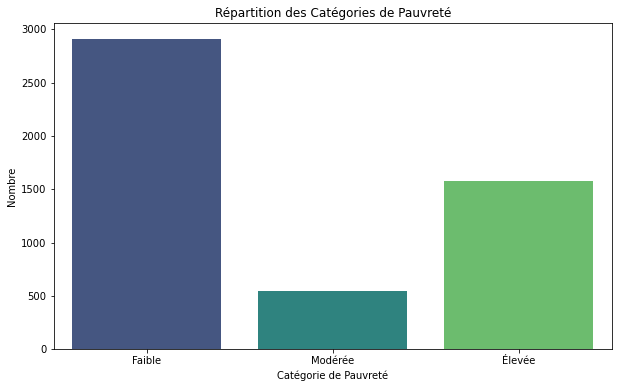

In [753]:
# Afficher la répartition des catégories
plt.figure(figsize=(10, 6))
sns.countplot(x='povertyCategory', data=df, palette='viridis')
plt.title('Répartition des Catégories de Pauvreté')
plt.xlabel('Catégorie de Pauvreté')
plt.ylabel('Nombre')
plt.show()

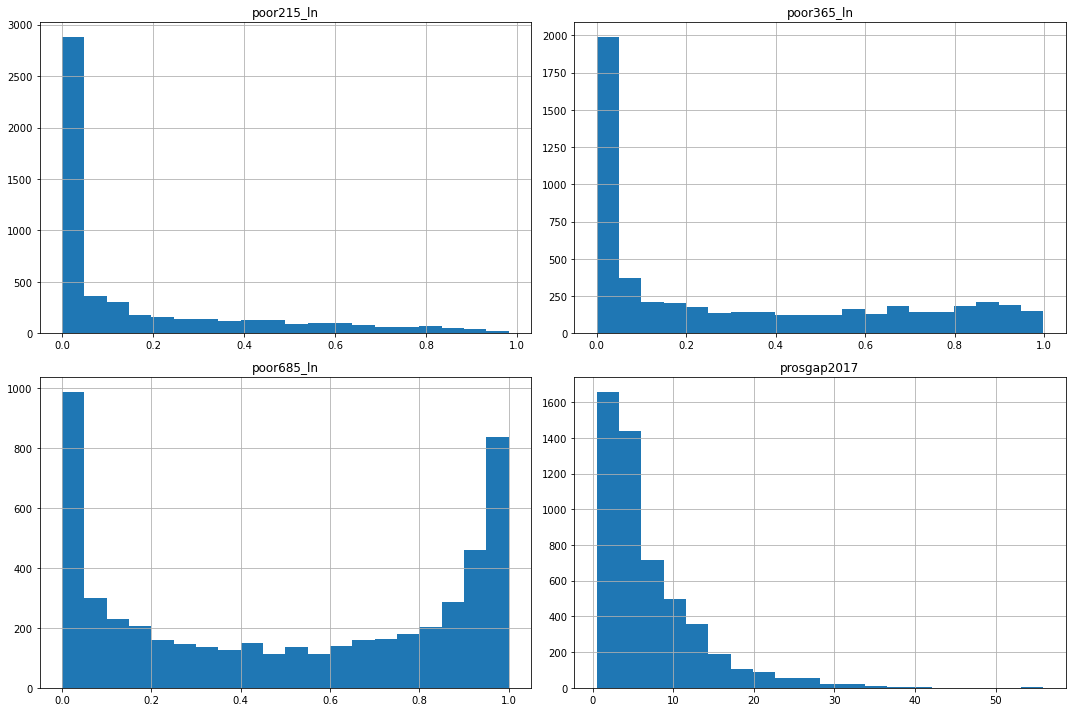

In [754]:
# Histogrammes
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

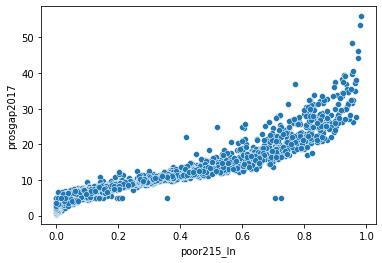

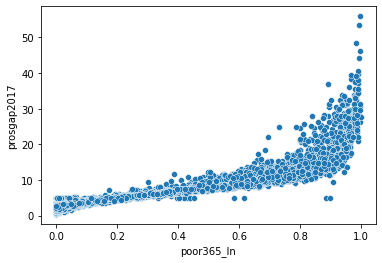

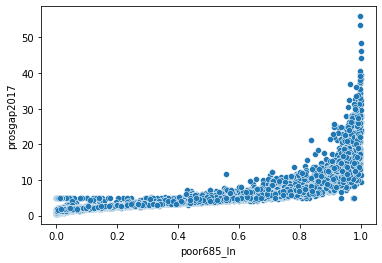

In [755]:
# Diagramme de dispersion
sns.scatterplot(x='poor215_ln', y='prosgap2017', data=df)
plt.show()

sns.scatterplot(x='poor365_ln', y='prosgap2017', data=df)
plt.show()

sns.scatterplot(x='poor685_ln', y='prosgap2017', data=df)
plt.show()

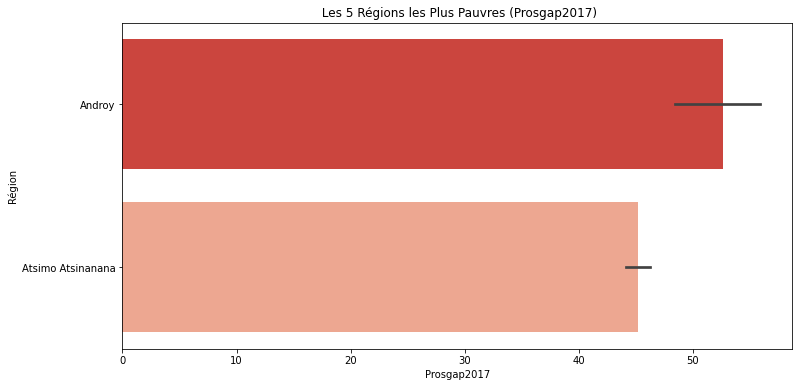

In [756]:
# Barplot pour les régions les plus pauvres
plt.figure(figsize=(12, 6))
sns.barplot(data=top5_poor, x='prosgap2017', y='sample', palette='Reds_r')
plt.title(' Les 5 Régions les Plus Pauvres (Prosgap2017)')
plt.xlabel('Prosgap2017')
plt.ylabel('Région')
plt.show()

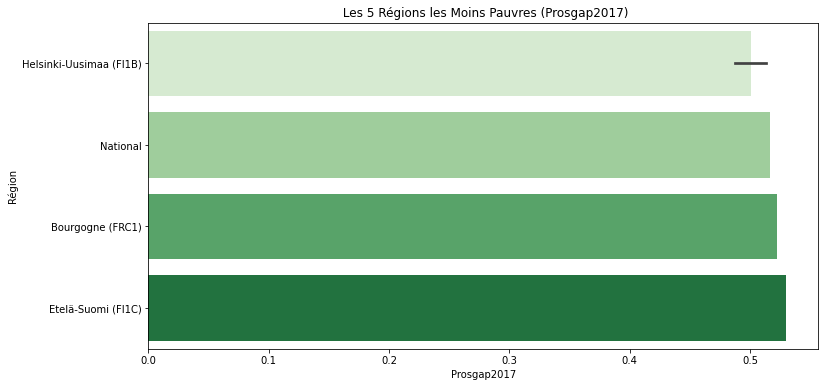

In [757]:
# Barplot pour les régions les moins pauvres
plt.figure(figsize=(12, 6))
sns.barplot(data=top5_rich, x='prosgap2017', y='sample', palette='Greens')
plt.title(' Les 5 Régions les Moins Pauvres (Prosgap2017)')
plt.xlabel('Prosgap2017')
plt.ylabel('Région')
plt.show()

# 4. Analyse Prédictive et Visualisation de la Pauvreté en Tunisie

Nous allons réaliser les étapes suivantes :

- Visualisation des disparités régionales en Tunisie
- Application d'un modèle prédictif pour estimer les taux de pauvreté

In [758]:
# Afficher un aperçu des données
print(df_tunisie.head())

     code  baseyear  lineupyear survname  welfaretype  \
1454  TUN      2010        2010  NSHBCSL          1.0   
1455  TUN      2010        2010  NSHBCSL          1.0   
1456  TUN      2010        2010  NSHBCSL          1.0   
1457  TUN      2010        2010  NSHBCSL          1.0   
1458  TUN      2010        2010  NSHBCSL          1.0   

                                                 sample    vintage  \
1454                                              Tunis  Fall 2024   
1455  Ariana & Ben Arous & Bizerte & Manouba & Nabeu...  Fall 2024   
1456                 Beja & Jendouba & Le Kef & Siliana  Fall 2024   
1457                  Mahdia & Monastir & Sfax & Sousse  Fall 2024   
1458                   Kairouan & Kasserine & Sidi Bouz  Fall 2024   

                 geo_code  poor215_ln  poor365_ln  poor685_ln  prosgap2017  \
1454  TUN_2015_GAUL1_3015      0.0000      0.0122      0.1493     2.314195   
1455     TUN_2015_GAULx_2      0.0032      0.0371      0.2885     3.112817   
14

In [759]:
print(df_tunisie.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 1454 to 5006
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   code              21 non-null     object  
 1   baseyear          21 non-null     int64   
 2   lineupyear        21 non-null     int64   
 3   survname          21 non-null     object  
 4   welfaretype       21 non-null     float64 
 5   sample            21 non-null     object  
 6   vintage           21 non-null     object  
 7   geo_code          21 non-null     object  
 8   poor215_ln        21 non-null     float64 
 9   poor365_ln        21 non-null     float64 
 10  poor685_ln        21 non-null     float64 
 11  prosgap2017       21 non-null     float64 
 12  geo_code2_new     21 non-null     object  
 13  poverty_weighted  21 non-null     float64 
 14  povertyCategory   21 non-null     category
dtypes: category(1), float64(6), int64(2), object(6)
memory usage: 2.6+ KB
N

In [760]:
print(df_tunisie.describe())

          baseyear   lineupyear  welfaretype  poor215_ln  poor365_ln  \
count    21.000000    21.000000         21.0   21.000000   21.000000   
mean   2017.333333  2016.666667          1.0    0.008333    0.045538   
std       5.313505     4.902380          0.0    0.013408    0.053936   
min    2010.000000  2010.000000          1.0    0.000000    0.000400   
25%    2010.000000  2010.000000          1.0    0.000900    0.014500   
50%    2021.000000  2019.000000          1.0    0.003200    0.027700   
75%    2021.000000  2021.000000          1.0    0.010600    0.053300   
max    2021.000000  2021.000000          1.0    0.055700    0.211400   

       poor685_ln  prosgap2017  poverty_weighted  
count   21.000000    21.000000         21.000000  
mean     0.243433     2.945595          1.043841  
std      0.151504     0.834502          1.087562  
min      0.032400     1.716128          0.056289  
25%      0.149300     2.431799          0.383495  
50%      0.195600     2.816712          0.639

In [761]:
# Répartition temporelle
print(df_tunisie['lineupyear'].value_counts())

2010    7
2019    7
2021    7
Name: lineupyear, dtype: int64


In [762]:
# Répartition géographique
print(df_tunisie['sample'].value_counts())

Tunis                                                         3
Ariana & Ben Arous & Bizerte & Manouba & Nabeul & Zaghouan    3
Beja & Jendouba & Le Kef & Siliana                            3
Mahdia & Monastir & Sfax & Sousse                             3
Kairouan & Kasserine & Sidi Bouz                              3
Gabes & Medenine & Tataouine                                  3
Gafsa & Kebili & Tozeur                                       3
Name: sample, dtype: int64


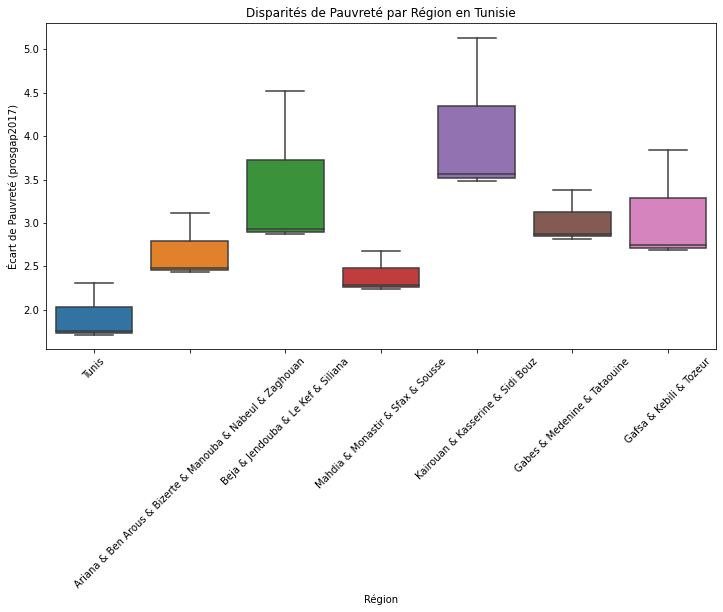

In [763]:
# Visualisation : Boxplot des écarts de pauvreté
plt.figure(figsize=(12, 6))
sns.boxplot(x='sample', y='prosgap2017', data=df_tunisie)
plt.xticks(rotation=45)
plt.title('Disparités de Pauvreté par Région en Tunisie')
plt.xlabel('Région')
plt.ylabel('Écart de Pauvreté (prosgap2017)')
plt.show()

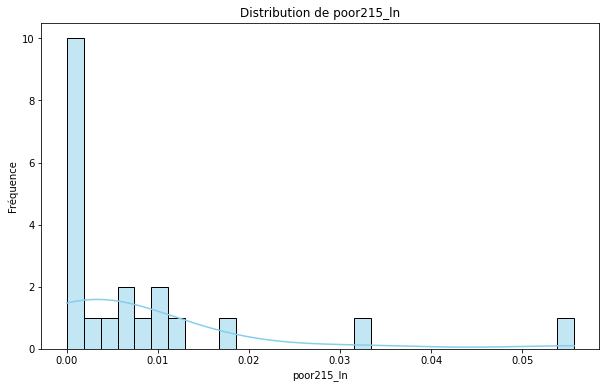

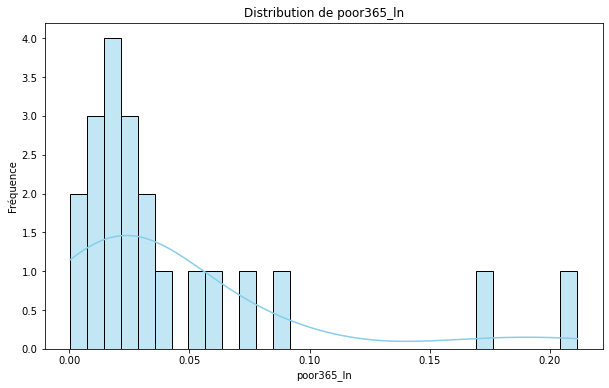

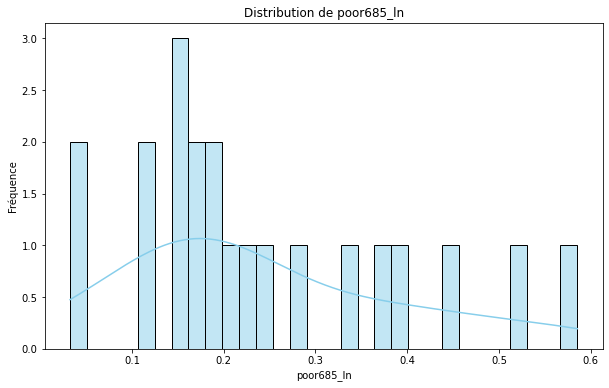

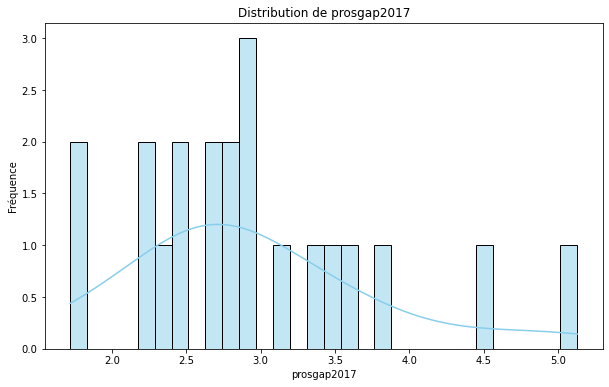

In [764]:
# Distribution des indicateurs de pauvreté
indicateurs = ['poor215_ln', 'poor365_ln', 'poor685_ln', 'prosgap2017']

for indicateur in indicateurs:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_tunisie[indicateur], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution de {indicateur}')
    plt.xlabel(indicateur)
    plt.ylabel('Fréquence')
    plt.show()

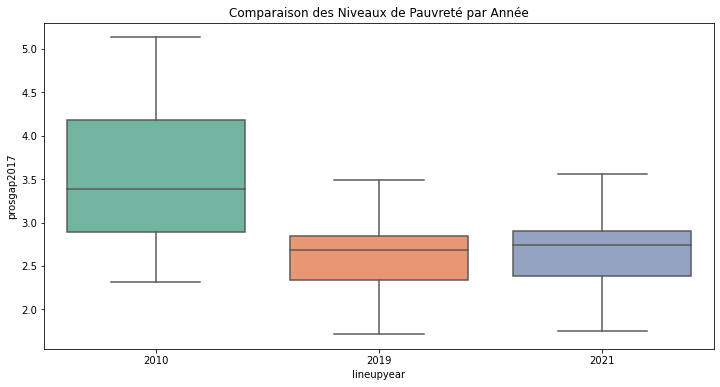

In [765]:
# Boxplots des indicateurs par année
plt.figure(figsize=(12, 6))
sns.boxplot(x='lineupyear', y='prosgap2017', data=df_tunisie, palette='Set2')
plt.title('Comparaison des Niveaux de Pauvreté par Année')
plt.show()

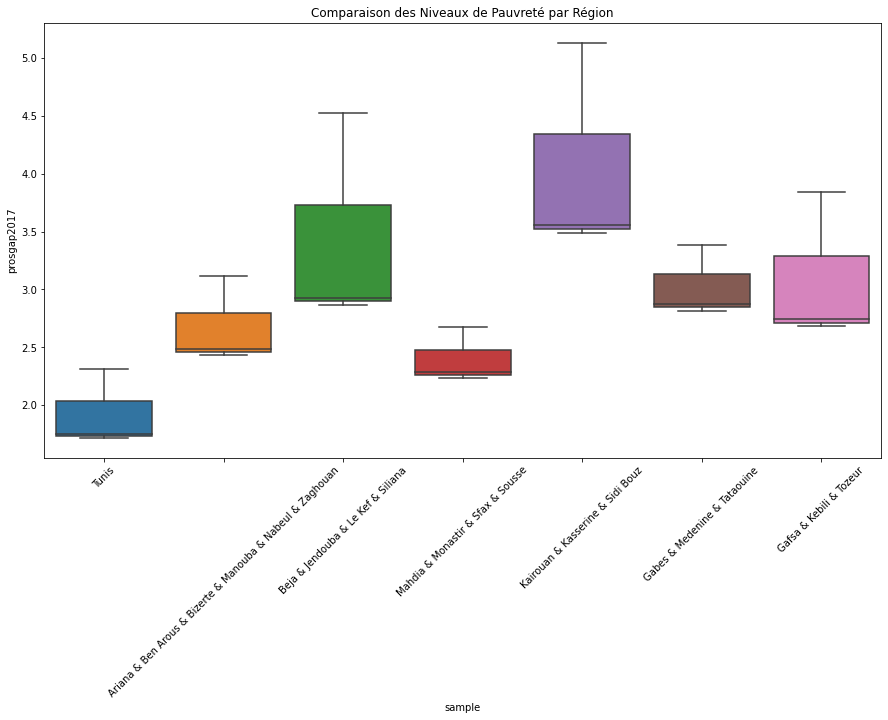

In [766]:
# Boxplots par région
plt.figure(figsize=(15, 8))
sns.boxplot(x='sample', y='prosgap2017', data=df_tunisie)
plt.xticks(rotation=45)
plt.title('Comparaison des Niveaux de Pauvreté par Région')
plt.show()

# Modélisation Prédictive

 1. Préparation des Données pour le Modèle

In [767]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Ajouter une colonne avec une valeur numérique unique pour chaque région (sample)
df_tunisie['sample_numeric'] = df_tunisie['sample'].astype('category').cat.codes

# Afficher un aperçu des données avec les nouvelles valeurs numériques
print(df_tunisie[['sample', 'sample_numeric']].drop_duplicates())

                                                 sample  sample_numeric
1454                                              Tunis               6
1455  Ariana & Ben Arous & Bizerte & Manouba & Nabeu...               0
1456                 Beja & Jendouba & Le Kef & Siliana               1
1457                  Mahdia & Monastir & Sfax & Sousse               5
1458                   Kairouan & Kasserine & Sidi Bouz               4
1459                       Gabes & Medenine & Tataouine               2
1460                            Gafsa & Kebili & Tozeur               3


C:\Users\akram\AppData\Local\Temp\ipykernel_15928\3582581157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tunisie['sample_numeric'] = df_tunisie['sample'].astype('category').cat.codes


In [768]:
# Sélection des variables pertinentes
X = df_tunisie[['baseyear', 'lineupyear','sample_numeric', 'poor685_ln']]
y = df_tunisie['prosgap2017']

In [769]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. Initialiser et entraîner le modèle

In [770]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [771]:
# Prédictions
y_pred = model.predict(X_test)

3. Évaluation du modèle

In [772]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) : {mse}")
print(f"Coefficient de Détermination (R²) : {r2}")

Mean Squared Error (MSE) : 0.015125350879594527
Coefficient de Détermination (R²) : 0.8349896728745412


# 7. Visualisation des Performances

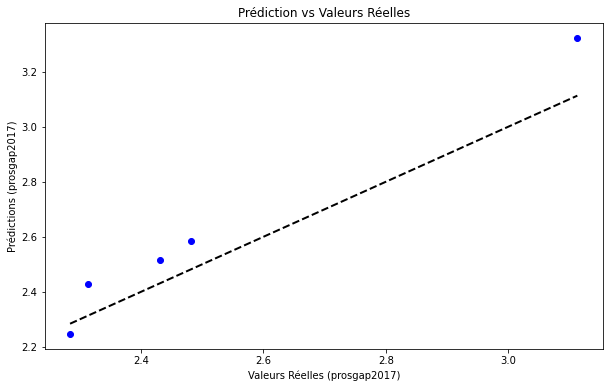

In [773]:
# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Prédiction vs Valeurs Réelles')
plt.xlabel('Valeurs Réelles (prosgap2017)')
plt.ylabel('Prédictions (prosgap2017)')
plt.show()